<a href="https://colab.research.google.com/github/AlirezaAhadipour/NN-from-scratch/blob/main/1_micrograd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [44]:
def f(x):
  return 3*x**2 -4*x + 5

In [45]:
f(3.0)

20.0

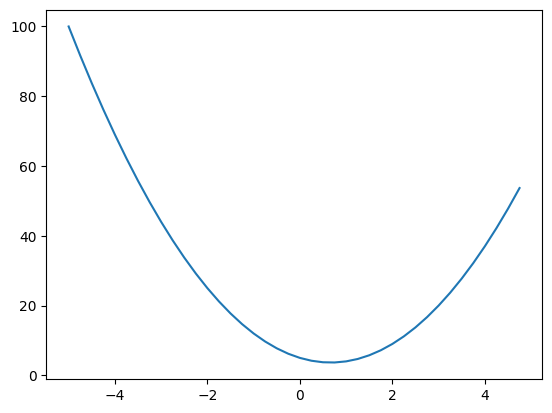

In [46]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [47]:
h = 0.001
x = 3.0
(f(x+h) - f(x))/h

14.00300000000243

In [48]:
a = 2.0
b = -3.0
c = 10.0

d = a*b + c
print(d)

4.0


In [49]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
a += h
d2 = a*b + c

print(f'd1', d1)
print(f'd2', d2)
print(f'slope', (d2 - d1)/h)

d1 4.0
d2 3.999699999999999
slope -3.000000000010772


In [50]:
class Value:
  def __init__(self, data):
    self.data = data

  def __repr__(self):
    return f'Value(data={self.data})'

  def __add__(self, other):
    out = Value(self.data + other.data)
    return out

  def __mul__(self, other):
    out = Value(self.data * other.data)
    return out

In [51]:
a = Value(2.0)
a

Value(data=2.0)

In [52]:
a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)
a*b + c

Value(data=4.0)

In [53]:
class Value:
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f'Value(data={self.data})'

  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad = 1.0 * out.grad
      other.grad = 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad = other.data * out.grad
      other.grad = self.data * out.grad
    out._backward = _backward

    return out

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad = (1 - t**2) * out.grad
    out._backward = _backward

    return out

In [54]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label='e'
d = e+c; d.label='d'
f = Value(-2.0, label='f')
L = d*f; L.label='L'
L

Value(data=-8.0)

In [55]:
d._prev

{Value(data=-6.0), Value(data=10.0)}

In [56]:
d._op

'+'

In [57]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

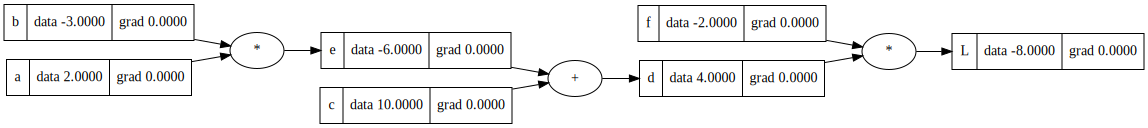

In [58]:
draw_dot(L)

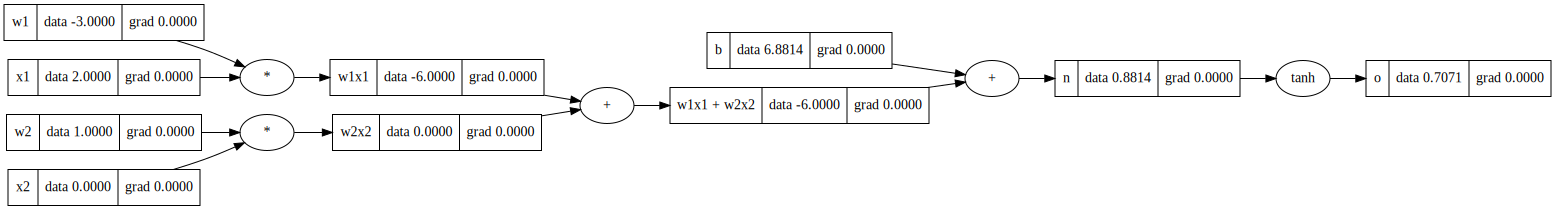

In [59]:
# input x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#bias
b = Value(6.8813735870195432, label='b')
#w1x1 + w2x2 + b
w1x1 = w1*x1; w1x1.label = 'w1x1'
w2x2 = w2*x2; w2x2.label = 'w2x2'
w1x1w2x2 = w1x1 + w2x2; w1x1w2x2.label = 'w1x1 + w2x2'
n = w1x1w2x2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
draw_dot(o)

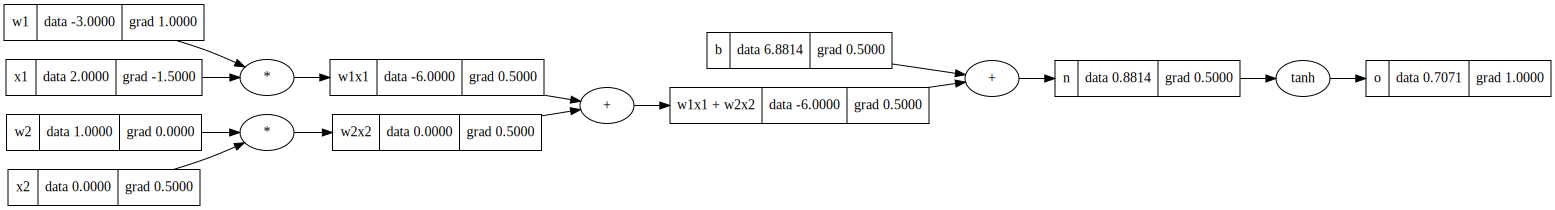

In [60]:
o.grad = 1.0
o._backward()
n._backward()
w1x1w2x2._backward()
w1x1._backward()
w2x2._backward()
draw_dot(o)

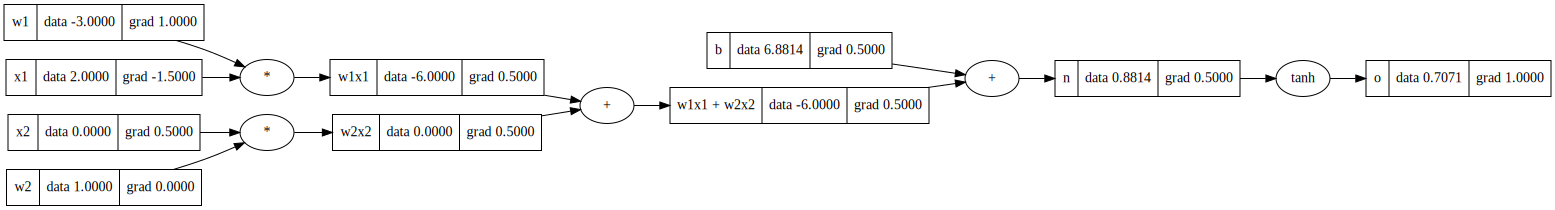

In [61]:
## automate the process

# input x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#bias
b = Value(6.8813735870195432, label='b')
#w1x1 + w2x2 + b
w1x1 = w1*x1; w1x1.label = 'w1x1'
w2x2 = w2*x2; w2x2.label = 'w2x2'
w1x1w2x2 = w1x1 + w2x2; w1x1w2x2.label = 'w1x1 + w2x2'
n = w1x1w2x2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'


# topological order
topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)

build_topo(o)

#back prop
o.grad = 1.0
for node in reversed(topo):
  node._backward()

draw_dot(o)

In [62]:
# put all toghether
class Value:
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f'Value(data={self.data})'

  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad = 1.0 * out.grad
      other.grad = 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad = other.data * out.grad
      other.grad = self.data * out.grad
    out._backward = _backward

    return out

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad = (1 - t**2) * out.grad
    out._backward = _backward

    return out

  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

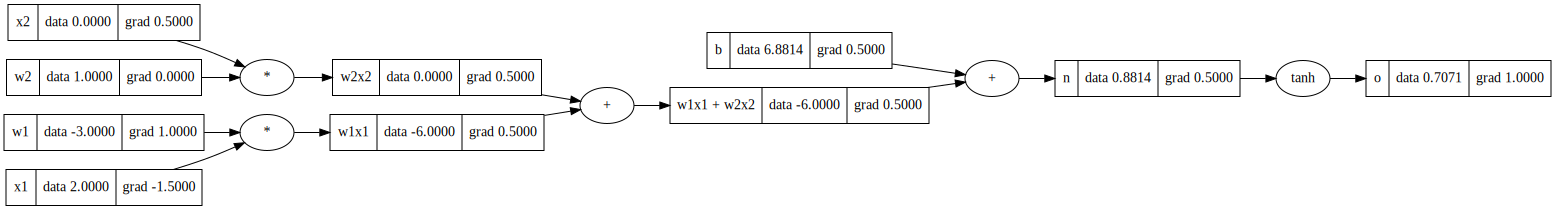

In [63]:
# input x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#bias
b = Value(6.8813735870195432, label='b')
#w1x1 + w2x2 + b
w1x1 = w1*x1; w1x1.label = 'w1x1'
w2x2 = w2*x2; w2x2.label = 'w2x2'
w1x1w2x2 = w1x1 + w2x2; w1x1w2x2.label = 'w1x1 + w2x2'
n = w1x1w2x2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

o.backward()
draw_dot(o)

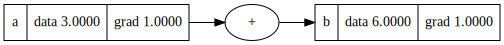

In [64]:
## one bug!!!
a = Value(3.0, label='a')
b = a + a; b.label = 'b'
b.backward()
draw_dot(b)

In [65]:
class Value:
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f'Value(data={self.data})'

  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out

  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

now, let's implement "tanh" in detail. to do so, we should implement add to integer (a+1), exponentiation, and division

In [66]:
class Value:
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f'Value(data={self.data})'

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)  # a + 1
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __neg__(self):
    return self * -1

  def __sub__(self, other):
    return self + (-other)

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)   # a * 2
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def __rmul__(self, other): # other * self   like 2*a
    return self * other

  def __pow__(self, other):
    assert isinstance(other, (int, float)), 'Only supporting int/float powers'
    out = Value(self.data ** other, (self, ), f'**{other}')

    def _backward():
      self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out

  def __truediv__(self, other):
    return self * (other**-1)

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward

    return out

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out

  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

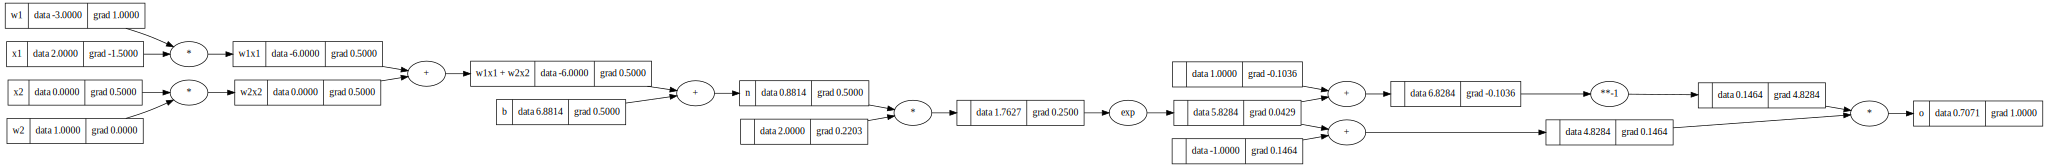

In [67]:
# input x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#bias
b = Value(6.8813735870195432, label='b')
#w1x1 + w2x2 + b
w1x1 = w1*x1; w1x1.label = 'w1x1'
w2x2 = w2*x2; w2x2.label = 'w2x2'
w1x1w2x2 = w1x1 + w2x2; w1x1w2x2.label = 'w1x1 + w2x2'
n = w1x1w2x2 + b; n.label = 'n'

# o = n.tanh(); o.label = 'o'
e = (2*n).exp()
o = (e-1)/(e+1)
o.label = 'o'

o.backward()
draw_dot(o)

# PyTorch

In [68]:
import torch

x1 = torch.Tensor([2.0]).double()
x1.requires_grad = True

x2 = torch.Tensor([0.0]).double()
x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()
w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()
w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()
b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)
print(o.data.item())

o.backward()
print('---')
print('x1', x1.grad.item())
print('w1', w1.grad.item())
print('x2', x2.grad.item())
print('w2', w2.grad.item())

0.7071066904050358
---
x1 -1.5000003851533106
w1 1.0000002567688737
x2 0.5000001283844369
w2 0.0


In [104]:
import random

class Neuron:
  def __init__(self, n_in):
    self.w = [Value(random.uniform(-1,1)) for _ in range(n_in)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    # w * c + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]


class Layer:
  def __init__(self, n_in, n_out):
    self.neurons = [Neuron(n_in) for _ in range(n_out)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    # return [p for neuron in self.neurons for p in neuron.parameters()]
    params = []
    for neuron in self.neurons:
      ps =  neuron.parameters()
      params.extend(ps)
    return params


class MLP:
  def __init__(self, n_in, n_outs):
    sz = [n_in] + n_outs
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(n_outs))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]


In [105]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.4689395132161335)

In [116]:
xs = [
    [2, 3, -1],
    [3, -1, 0.5],
    [0.5, 1, 1],
    [1, 1, -1]
]

ys = [1, -1, -1, 1]   # desired targets

In [117]:
y_pred = [n(x) for x in xs]
y_pred

[Value(data=0.9036398686165218),
 Value(data=-0.9999809517416263),
 Value(data=-0.9999996352840193),
 Value(data=0.9166374346112265)]

In [118]:
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, y_pred)], Value(0))
loss

Value(data=0.016234592591407887)

In [110]:
loss.backward()

In [111]:
for p in n.parameters():
  p.data += -0.1 * p.grad

In [112]:
y_pred = [n(x) for x in xs]
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, y_pred)], Value(0))
loss

Value(data=3.799997896734104)

In [113]:
y_pred

[Value(data=0.5016997530002882),
 Value(data=-0.146553912251912),
 Value(data=0.4518374804981284),
 Value(data=0.15413212254959122)]

In [119]:
for k in range(10):
  # forward pass
  y_pred = [n(x) for x in xs]
  loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, y_pred)], Value(0))

  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad

  print(k, loss.data)

0 0.016234592591407887
1 0.01033764966183916
2 0.00783463092517581
3 0.006386746068735585
4 0.00542755058623937
5 0.004739563283704808
6 0.004219301996498485
7 0.003810649123895003
8 0.0034803203892936176
9 0.0032072327469922102


In [120]:
y_pred

[Value(data=0.9574309347758504),
 Value(data=-0.9999757735202855),
 Value(data=-0.9999996374243064),
 Value(data=0.9626488708888135)]